# **SCDAA Coursework 2024-2025**
---

In [57]:
import utils.exercises1_1 as ex1_1
import utils.exercises1_2 as ex1_2
import matplotlib.pyplot as plt
import importlib
import torch

## **Exercise 1.1 (Solving LQR using from Ricattic ODE)**

Write a class which:
1. Can be initialised with the matrices specifying the LQR problem and $T > 0$ and a time grid (numpy array or torch tensor). 
2. Has a method which will solve (approximate) the associated Ricatti ODE on this time grid. 
3. Has a method that, given one torch 1d-tensor (for time) and another torch 2d-tensor (for space), will return a 1d-torch tensor the control problem value $v(t, x)$ for the given $t, x$. If t is not on the time grid use $t_n$ which belongs to the grid and is the the nearest to $t$ (or the biggest $t_n$ smaller than $t$). 
4. Has a method that, given one torch 1d-tensor (for time) and another torch 2d-tensor (for space), will return a 2d-torch tensor with entries being the optimal Markov control function for the given $t, x$ i.e..

In [59]:
importlib.reload(ex1_1)

# (1)Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5
time_grid = torch.linspace(0, T, 100)

# (2)Initialize LQR function (include solving the associated Ricatti ODE)
lqr = ex1_1.LQR(H, M, C, D, R, sigma, T, time_grid)

# Initialize t and x
t0 = 0
x0 = torch.tensor([1.0, 1.0])

# (3)Solve the value function v(t, x)
v = lqr.value_function(t0, x0)
print("Value function v(t, x):", v.item())

# (4)Solve the optimal control a(t, x)
a = lqr.optimal_control(t0, x0)
print("Optimal control a(t, x):", a.tolist())

Value function v(t, x): 0.7837988138198853
Optimal control a(t, x): [-1.2770087718963623, -5.199576377868652]


## **Exercise 1.2 (LQR MC checks)**

Run a Monte Carlo simulation of the system with the optimal solution you have obtained and ensure that you’re converging to the optimal value function you obtained in Exercise 1.1. You should check at least the case $t = 0$ and $x = (1, 1)$ and say $x = (2, 2)$ but of course few more would do no harm. In principle the value function is defined on the whole of $[0, T] \times R^2$ so we should check many more points against e.g. supremum norm but running the tests on some grid in this will get very computationally heavy very fast. 

Fix $T = 1/2$. In particular what we want to see:
1. With number of Conte Carlo samples large (e.g. 10000) vary the number of time steps in your simulation, take $2^1$, $2^2$, . . . , $2^{11}$ and plot the error as a log-log plot. What is the expected convergence rate and what do you observe? 
2. With a number of time steps large e.g. 10000 vary the number of Monte-Carlo samples, take $2 \cdot 4^0$, $2 \cdot 4^1$, . . . , $2 \cdot 4^5$ and plot the error as a log-log plot. What is the expected convergence rate and what do you observe?

*Hint:* Let $a = a(t, x)$ denote the optimal control from Exercise 1.1. Once you’ve plugged this in (1) you get 
```math
dX_s = [HX_s + Ma(s, X_s)] ds + \sigma dW_s , \quad s \in [t, T] ,\quad X_t = x
```
To do a time discretisation fix $N \in \mathbb{N}$ (number of time steps); let $\tau := T/N$ be the time step. Assume from now that you’d only possible want to start the SDE at times $t_k = k\tau$ for some $k = 0, 1, . . . , N$. You have a choice of (at least) two schemes since you know $a(t, x) = −D^{−1}M_TS(t)x$.

Explicit: 
```math
X_{t_{n+1}}^{N} = X_{t_n}^{N} + \tau [HX_{t_n}^N − MD^{−1}M_TS(t_n)X_{t_n}^N )] + \sigma (W_{t_{n+1}}−W_{t_n} ), \quad n = k, . . . , N , \quad X_{t_k}^N = x . 
```
Implicit: 
```math
X_{t_{n+1}}^{N} = X_{t_{n+1}}^{N} + \tau [HX_{t_{n+1}}^N − MD^{−1}M_TS(t_{n+1})X_{t_{n+1}}^N )] + \sigma (W_{t_{n+1}}−W_{t_n} ), \quad n = k, . . . , N , \quad X_{t_k}^N = x . 
```

In [64]:
importlib.reload(ex1_2)

# Initialize matrix values
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5

# Initialize t and x
t0 = 0
x0 = torch.tensor([1.0, 1.0])

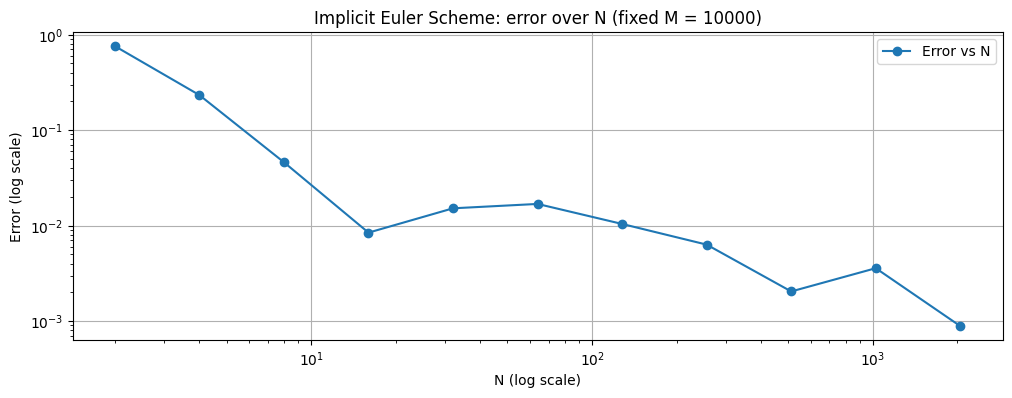

In [65]:
# (1) Fixed M, change N, observe the error
M_samples_fixed = 10000
N_step_list = [2 ** k for k in range(1, 12)]  # 2^1 到 2^11

err_N = ex1_2.error_on_N(H, M, C, D, R, sigma, T, M_samples_fixed, N_step_list, v, t0, x0)
ex1_2.loglog_plot(N_step_list, err_N, 'M', 'N')

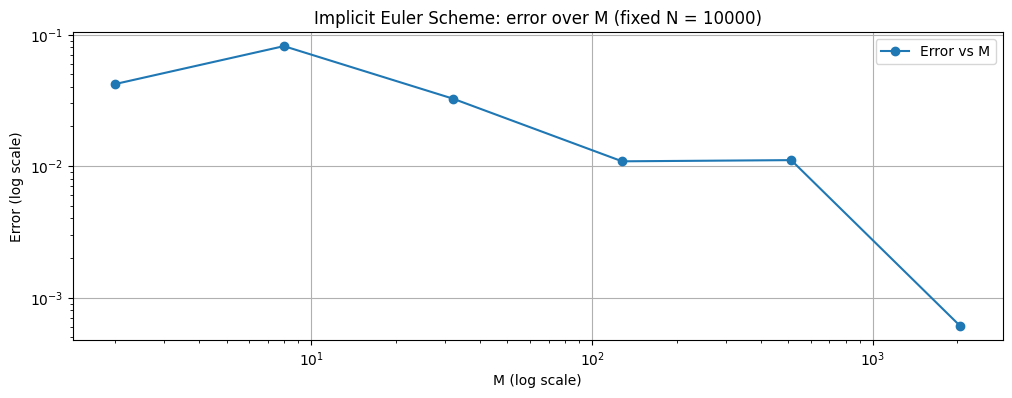

In [67]:
# (2) Fixed N, change M, observe the error
N_fixed = 10000
M_samples_list = [2 * 4 ** k for k in range(6)]

# print(M_samples_list, err_M)
err_M = ex1_2.error_on_M(H, M, C, D, R, sigma, T, N_fixed, M_samples_list, v, t0, x0)
ex1_2.loglog_plot(M_samples_list, err_M, 'N', 'M')